## Using Monte Carlo methods to estimate pi

Importing libraries and initialising global constants

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import concurrent.futures
import unittest
import pytest

In [4]:
radius = 1
points = [10, 100, 1000, 10000]
number_of_tests = 1000

Writing functions to find pi estimates based on the number of randomly selected points that fall within a quarter circle confined to a square. The ratio of points inside the square to total points is equal to 4*pi. Two functions created: one generates a graph with the result, and the other doesn't (designed to be run multiple times)

In [6]:
def generate_2d_points(num_points):
    """
    Generates randomly distributed 2D points and stores them in arrays

    PARAMETERS:
    points_array: array

    OUTPUT:
    xpoints: a list of randomly generated x-coordinates
    ypoints: a list of randomly generated y-coordinates
    """
  
    xpoints = np.random.uniform(low = 0, high = radius, size = num_points)
    ypoints = np.random.uniform(low = 0, high = radius, size = num_points)

    return xpoints, ypoints

def find_circle_coords(radius_input):
    """
    Finds the coordinates of a quarter-circle of a given radius (centered on the origin)

    PARAMETERS:
    radius_input: float

    OUTPUT:
    circle_xpoints: array
    circle_ypoints: array
    """

    circle_xpoints = np.linspace(0, radius_input, 100000)
    circle_ypoints = []

    for xpoint in circle_xpoints:
        circle_ypoints.append(np.sqrt((radius_input ** 2) - (xpoint ** 2)))

    return circle_xpoints, circle_ypoints

def find_pi_estimate(x_coords, y_coords, num_points):
    """
    Calculates a single estimate of pi based on the number of points that lie within the quarter circle. The ratio of points inside the quarter circle to
    total points is equal to 4 * pi.
    """

    inside_count = 0
    outside_count = 0

    for i in range(num_points):
        if ((x_coords[i] ** 2) + (y_coords[i] ** 2)) > (radius ** 2):
            outside_count += 1
        elif ((x_coords[i] ** 2) + (y_coords[i] ** 2)) < (radius ** 2):
            inside_count += 1

    pi_estimate = 4 * (inside_count / (inside_count + outside_count))
    error = abs((np.pi - pi_estimate) / np.pi)
    
    return pi_estimate, error

def plotting(ax, x_points, y_points, circle_x_points, circle_y_points):
    """
    Plots a graph and prints relevant data
    """

    ax.axhline(y = 0, xmin = 0, xmax = 1, color = "r")
    ax.axhline(y = radius, xmin = 0, xmax = 1, color = "r")
    ax.axvline(x = 0, ymin = 0, ymax = 1, color = "r")
    ax.axvline(x = radius, ymin = 0, ymax = 1, color = "r")


    #plotting the graph
    ax.plot(circle_x_points, circle_y_points, color = "r")
    ax.scatter(x_points, y_points, marker = "+", color ="b")

    return

def multiple_estimates(num_points, radius_in):
    """
    Uses the finding_pi_estimate function to generate estimates for pi. Repeats this a set number of time, and averages all of the pi estimates for 
    each set of points separately. Prints statements about the final pi estimates for each respective set of points. Uses parallel executor to optmise
    the process.
    """
    total = 0
    results = []

    #using parallel process to find many pi estimates and store them all in 'results' array
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for i in range(number_of_tests):
            x, y = generate_2d_points(num_points)
            result, percentage_error = find_pi_estimate(x, y, num_points)
            results.append(result)

    #finding the mean result for each set number of points
    total = np.sum(results, axis = 0)
    mean = total / number_of_tests


    return mean

estimate for 10 points, 1000 tests is 3.1444 (0.09% error)
estimate for 100 points, 1000 tests is 3.14012 (0.05% error)
estimate for 1000 points, 1000 tests is 3.141892 (0.01% error)
estimate for 10000 points, 1000 tests is 3.1415712000000005 (0.00% error)


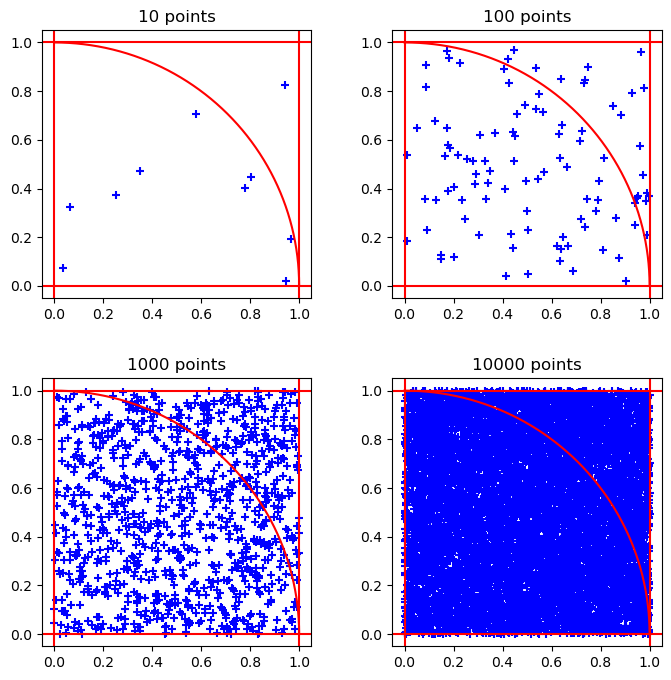

CPU times: total: 9.75 s
Wall time: 9.95 s


In [29]:
%%time
fig = plt.figure(figsize = [8,8])
subplot_grid = gridspec.GridSpec(2,2, wspace = 0.3, hspace = 0.3)


x_points = []
y_points = []
estimates = []
results = []
errors = []

circle_x, circle_y = find_circle_coords(radius)

for i in range(len(points)):
    x, y = generate_2d_points(points[i])
    x_points.append(x)
    y_points.append(y)

    estimate, error = find_pi_estimate(x, y, points[i])
    estimates.append(estimate)
    errors.append(error)
    #print(estimate)

    subplot = fig.add_subplot(subplot_grid[i])
    plotting(subplot, x, y, circle_x, circle_y)
    subplot.set_title("{0} points".format(points[i]))

    result = multiple_estimates(points[i], radius)
    results.append(result)

    percentage_error = abs((np.pi - result) / np.pi) * 100
    print("estimate for {0} points, {1} tests is {2} ({3:.2f}% error)".format(points[i], number_of_tests, result, percentage_error))
   
plt.show()

comparing statistical (predicted) vs actual error

[10, 100, 1000, 10000]
[0.1459155902616465, 0.005859240340778607, 0.02979146691180598, 0.0025441406544735316]


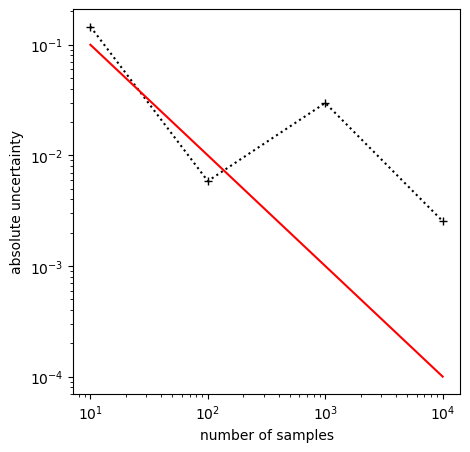

In [43]:
def calculate_statistical_error(num_points):
    return (1 / num_points)

def plot_errors(figure, points_array, statistical_errors, real_errors):
    plt.loglog(points_array, real_errors, marker = "+", linestyle = "dotted", color = "k", label = "real errors")
    plt.loglog(points_array, statistical_errors, color = "r", label = "statistical (predicted) error")
    plt.xlabel("number of samples")
    plt.ylabel("absolute uncertainty")

    return

fig = plt.figure(figsize = [5, 5])
statistical_error = []

for i in range(len(points)):
    stat_error = calculate_statistical_error(points[i])
    statistical_error.append(stat_error)

print(points)
print(errors)
plot_errors(fig, points, statistical_error, errors)
plt.show()

Practising basic testing

In [9]:
class TestNotebook(unittest.TestCase):

    def test_finding_pi_estimate(self):
        self.assertAlmostEqual(np.pi, 3.14159265)
        self.assertAlmostEqual(np.pi, 3.142)

if __name__ == "__main__":
    unittest.main(argv=["first-arg-is-ignored"], exit = False, verbosity = 3)

test_finding_pi_estimate (__main__.TestNotebook.test_finding_pi_estimate) ... FAIL

FAIL: test_finding_pi_estimate (__main__.TestNotebook.test_finding_pi_estimate)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\prw67787\AppData\Local\Temp\ipykernel_1512\3867646859.py", line 5, in test_finding_pi_estimate
    self.assertAlmostEqual(np.pi, 3.142)
AssertionError: 3.141592653589793 != 3.142 within 7 places (0.0004073464102067881 difference)

----------------------------------------------------------------------
Ran 1 test in 0.003s

FAILED (failures=1)
